# Executive Summary
---

### 1. Project Overview
- **Business Goal:** Use the Hitters dataset to predict an MLB player's 1987 salary given 1986 statistics, total career statistics, and a handful of other features.

- **Data Summary:**
    - *Observations (Players):* 322
    - *Features:* AtBat, Hits, HmRun, Runs, RBI, Walks, Years, CAtBat, CHits, CHmRun, CRuns, CRBI, CWalks, League, Division, PutOuts, Assists, Errors, Salary, NewLeague
    - *Target:* Salary
    - *Missing Salaries:* 59
    - About 20% of the salaries are missing from the dataset. Given our small sample size, the decision was made to impute or pre-estimate these salaries prior to modelling to keep as much data as possible. 

### 2. Methodology:
In subsquent sections, we'll cover 3 different model approaches to predicting salary, each with different sets of features and assumptions. The first model built is a linear regression; it's simplistic and sets a relatively naive baseline for subsequent models. We can also interpret linear regression easily and have high-level discussions around it. The second model is another linear regression but with an enhanced feature set that is trimmed down using LASSO. Here we begin to see what features are important and identify shortcomings in the dataset all while preserving easy interpretation. Finally, a random forest is built using all engineered features and tuned with hyperparamaters. This model was selected to pick up on non-linearities and complex patterns in the dataset, while reducing the chances of overfitting. XGBoost was also considered for the final model, however I did not look into it because I was concerned about overfitting on a noisy dataset (initial linear regression residuals appeared very unstable).

### 3. Analysis:
*See subsequent sections for analysis, code, and documented thought process*

### 4. Results: 
*Reported in order from linear regression, to lasso linear regression, to random forest*
- RMSE: 325.55 -> 337.65 -> 326.91
- MAE: 203.58 -> 213.38 -> 182.85
- R2: 0.4721 -> 0.4095 -> 0.6985

We're able to explain about 70% of salary drivers with the final model, meaning that we have a decent grasp on what influences salary even with a limited dataset. Overall, career stat totals and per-year averages are the most important features since they underscore a players impact and consistency. The instability of the first two linear models is indicative of more complex relationships and supports the case for using a Random Forest or other tree-based approach. Our dataset is too small to begin thinking about Neural Networks especially with its inherent noise/limitations.

The model would still need significant work before being used in production due to its average error of $183k per prediction (though this number is upwardly biased by outliers). Reframing the business use-case from salary prediction model to free agent negotiation tool will allow us to have a greater focus and impact (more on this in Section 5 Looking Ahead).

**Findings and Insights:**

The final model was about 15% more effective in terms of MAE relative to the baseline (and this is underselling the improvements since the baseline was also thoughtfully created). Random Forest did a fantastic job splitting percieved rookie contracts from veteran ones, which means the model can generalize to the entire base of players. Engineered features as a whole were important in making model improvements: 4 out of the top 10 most important RF features were per-year performance features. Outliers remain an issue but predictions tightened around a residual of zero as the model was enhanced. Consequently, this model isn't the best for elite players, but generalizes fairly well to others.

**Limitations:**

Outlier problems were never really solved which is partly due to the data and partly a fault of the feature engineering process. Regarding the data, we are missing several key features such as Team, Contract Length, Injury History, Rookie Contract Details, Position, All Star appearances, etc. These are important signals that would help add context to our worst predictions. As far as the feature engineering process, I would floor and cap data in a v4. Even after log transforms, the tails on data can be pretty extreme, which, to me, indicates that some players are substantially better than even other top players. However I don't believe the production gap would result in the same salary disparity based on my knowledge of current baseball salaries (i.e. Bryce Harper and Aaron Judge make comparable amounts, but Judge is a signficantly better hitter and provides more value in the field.) It would be interesting to remove some of the tail bias from the data and see how the model generalizes again. 

I would also look into creating separate models for RookiesContracts (as I've defined them) and veteran players, or simply removing RookieContract players altogether. These groups are structually different and it's hard for me see a scenario where we care about predicting rookie salary because it appears artifically capped. It would make more sense to train the model on veteran players and then predict on rookies under contract to get a clearer picture of their real market value. That insight would help tremendously in free agent negotiations when they do hit the open market.

### 5. Looking Ahead

**Next Steps/Business Opportunities:**

*All recommendations made assuming we own this data and have access to more features in our database.*
1. **Pull in additional player and league data to enhance the model**
    - Knowing player positions, league awards, injury history, etc are all critically important to determining a player's long-term value
2. **Reframe the model opportunity from salary prediction to free agent negotiation tool/long-term value estimation**
    - As stated, predicting salaries across the board is a fun exercise, but it's not the most valuable from a business perspective because we can only acquire players through the draft, trades, or free agency. What we'd really like to do is target active players and understand what we should be paying them based on their value. Providing a salary range to the front office will allow them to be more informed when they enter into negotiations with a player and their agent. Further, an additional model to estimate a player's long-term value will help us understand how much a player is worth on the market for the next X years rather than next year alone. Contracts are often multi-year commitments, so it's important to maximize value over the life of the contract.
3. **Work with the business to identify outliers and agree upon ways to address them**
    - Addressing outliers is a major opportunity for model improvement, but analyzing a fixed feature set can't uncover all hidden signals. Collaborating with business experts is essential to building a model that captures all relevant information, especially when working with a small sample size. The GM may know to exclude Player 1 from the dataset because his salary was negotiated for reasons that had nothing to do with statistics. 

___

# Technical Work
___
## Roadmap
1. Initial Analysis
    - First Thoughts
    - Deeper EDA
    - Feature Engineering (first pass)
2. Linear Regression Model
    - Feature Selection
    - Model Building
    - Results Reporting
2. Linear Regression Model with LASSO
    - Feature Selection
    - Model Building
    - Results Reporting
2. Random Forest
    - Feature Selection
    - Model Building
    - Results Reporting

___

# 1. Initial Analysis

## 1.1 Data Load + First Thoughts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load
path = '../data/Hitters.csv'
df = pd.read_csv(path)

# Preview
df.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


**Notes:**
- **At a glance, I see NaNs in the Salary column. Since we're trying to predict Salary, we'll need to drop these players from the dataset or impute the values.** 
    - My initial feeling is to drop the values because I don't know why they are missing and I'd hesitate to introduce bias. But, depending on how the rest of EDA goes, these values may be imputed.
- **We don't know how long each player has been under contract, which makes estimating the predicted Salary a much more difficult exercise.**
    - Several dynamics affect salaries in professional sports: CBAs, broadcast deals, owner turnover, etc. We can't control for any of these which means a player who signed a 4yr/2mil contract in 1984 might actually be worth 2mil a year in 1987. Attempting to adjust for inflation as a proxy for market changes is an option, but that introduces noise and is not advisable given how little is known about the data.
- **League, Division, and NewLeague are all binary or categorical variables that we should create along with interaction terms such as League_Division.**
    - League tells us a player's league in the 1986 season, while NewLeague tells us their new league in 1987. We can use these variables to create a SwitchedLeague variable that in theory will absorb the impact of league on salary. SwitchedLeague may turn out to not be important, but it's worth creating prior to EDA. 
    - I would have assumed Division to be a categorical variable given current baseball divisions, but per the docs it's also binary (E, W). This feature can potentially be used to control for market specific effects on contracts. It's possible that the AL East has inflated salaries because the Red Sox and Yankees are high spenders, so we'd want to control for each league and division combination. Further, because they are typically more active in the free-agent market (at least today), I'd hypothesize that players switching leagues into the AL East (SwitchedLeague==1 & AE==1) will see more inflated contracts than players who switched leagues to a different division. Unfortunately we don't have a NewDivision variable, so we can't control for this scenario.
- **Years and Career (C...) variables allow us to engineer features that capture consistency and potential future improvement.**
    - If a player's numbers were generally better in 1986 relative to their career averages (imagine some sort of composite performance score) than they may be improving and therefore demanding a higher salary in the market than their career numbers suggest. This is especially true with younger players who have more potential to grow than established veterans. Engineering *Improvement* and *Improvement_Years* features can capture the effects of player growth, while helping to determine whether or not that growth was legitimate. I.e. A team isn't going to pay a 13 year vet following a career year in the same way that they'd pay a 4 year vet in the same situation.  
        - I won't be engineering improvement features in the interest of time, but I will engineer per-year features. It would require a separate EDA and potentially another model to develop an improvement metric.
- **Variables can differ in magnitude by 100x which means they should be scaled depending on the algorithm.**
    - Gradient descent algorithms and many feature selection methods (PCA/Lasso/Ridge) simply don't work with unscaled features and this problem exacerbates itself as differences in scale increase. At the very least, we'll need scaled features for the selection process, so those will be created as needed throughout the notebook.
- **After feature engineering, we'll have somewhere in the neighborhood of 30-40 features vs 300 observations.**
    - This ratio isn't unmanageable, but it's likely that many of these features are capturing the same signal (home runs and RBI impact on salary). Feature selection will be necessary to trim this list down and prevent the model from overfitting based on noise. Additionally, linear regression requires features to not be related to one another if coefficients are meant to be interpreted. We're building ML models so it's not a huge deal to violate this assumption, but we do need to keep in my that coefficient values may not represent relationships in reality. Coefficients should only be interpreted for general magnitude and direction.

## 1.2 Data Summary

In [3]:
# Data size/shape
print('DATA CHARACTERISTICS\n----------------')
print(f'Variables: {len(df.columns)-1}')
cont_vars = (df[df.columns.difference(['Salary'])].dtypes==(int or float)).sum()
cat_vars = (df[df.columns.difference(['Salary'])].dtypes!=(int or float)).sum()
print(f'Continuous/Discrete Variables: {cont_vars}')
print(f'Categorical/Indicator Variables: {cat_vars}')
print(f'Players (Observations): {len(df)}')
print(f'Trainable Observations: {df.Salary.notna().sum()}')

# Nulls
print('\nNULL ENTRIES\n------------')
for col in df.columns: 
    nulls = df[col].isna().sum()
    if nulls > 0:
        print(f'{col}: {nulls}, {(nulls*100/len(df)).round(2)}%')
        
# Dataframe Summary Stats
print('\nSUMMARY STATS\n--------------')
        
        
df.describe().T.round(2)

DATA CHARACTERISTICS
----------------
Variables: 19
Continuous/Discrete Variables: 16
Categorical/Indicator Variables: 3
Players (Observations): 322
Trainable Observations: 263

NULL ENTRIES
------------
Salary: 59, 18.32%

SUMMARY STATS
--------------


,count,mean,std,min,25%,50%,75%,max
AtBat,322.0,380.93,153.40,16.0,255.25,379.5,512.00,687.0
Hits,322.0,101.02,46.45,1.0,64.00,96.0,137.00,238.0
HmRun,322.0,10.77,8.71,0.0,4.00,8.0,16.00,40.0
Runs,322.0,50.91,26.02,0.0,30.25,48.0,69.00,130.0
RBI,322.0,48.03,26.17,0.0,28.00,44.0,64.75,121.0
Walks,322.0,38.74,21.64,0.0,22.00,35.0,53.00,105.0
Years,322.0,7.44,4.93,1.0,4.00,6.0,11.00,24.0
CAtBat,322.0,2648.68,2324.21,19.0,816.75,1928.0,3924.25,14053.0
CHits,322.0,717.57,654.47,4.0,209.00,508.0,1059.25,4256.0
CHmRun,322.0,69.49,86.27,0.0,14.00,37.5,90.00,548.0


### 1.2.1 How do missing and non-missing Salary groups compare?

In [4]:
# Create null salary variable and compare means
null_df = df.copy()
null_df['NullSalary'] = [0 if sal>=0 else 1 for sal in null_df.Salary]
null_df.groupby('NullSalary').mean().T

NullSalary,0,1
AtBat,403.642586,279.677966
Hits,107.828897,70.694915
HmRun,11.619772,6.983051
Runs,54.745247,33.813559
RBI,51.486692,32.610169
Walks,41.114068,28.169492
Years,7.311787,8.033898
CAtBat,2657.543726,2609.186441
CHits,722.186312,697.000000
CHmRun,69.239544,70.610169


**Notes:**
- **Averages look similar across the board for all variables which means the data is probably missing at random or is missing in a way that imputation should not significantly bias the model.**
    - There are a bunch of different ways to impute the data which we'll do after initial feature engineering steps. It's likely that we'll come across new features that will contribute positively to the imputation process.
        - I'm concerned about amplifying noise with imputation, but the dataset is so small that I think the trade-off is worth it. Given more time I would run the notebook for the imputed and non-imputed target to make a more informed decision.

### 1.2.2 What do feature distributions look like for the dataset? 
- This section will reveal skew, outliers, and provide insight into underlying trends that may inform the feature engineering process.

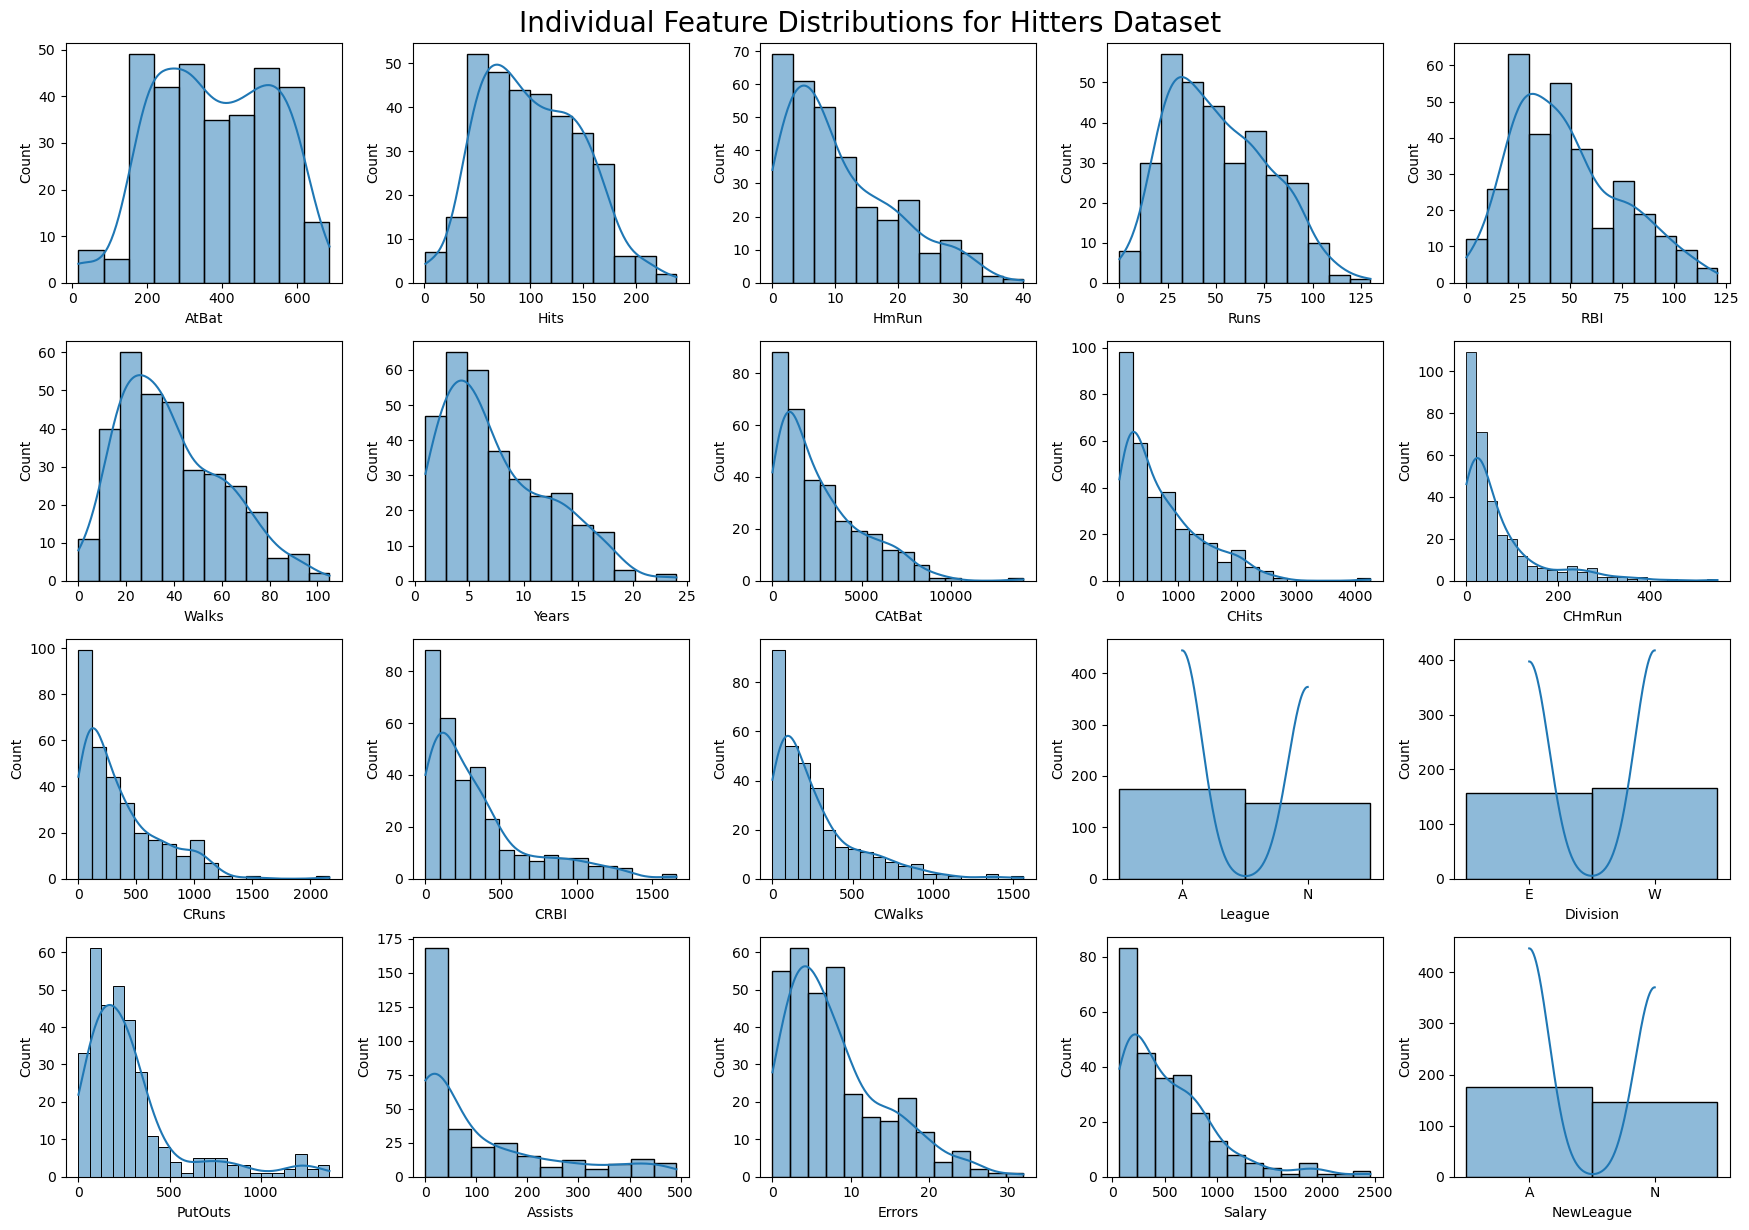

In [5]:
# Plot distributions
fig, ax = plt.subplots(4, 5, figsize=(17.5,12.5))
ax = ax.flatten()

for idx, feature in enumerate(df.columns):
    sns.histplot(df[feature], ax=ax[idx], kde=True)
fig.suptitle('Individual Feature Distributions for Hitters Dataset', size=20)
fig.tight_layout()

plt.show()

**Notes:**
- **Lacking positional data will make modeling a bit of a pain, particularly when it comes to measuring defensive value.** Both Assists and PutOuts have long tails relative to the rest of the features in the dataset and this is purely a product of position. In theory, it would be possible to back out positions based on baseball knowledge and a metric like Assist-to-PutOut ratio, but that's out of scope for this exercise (and not a good use of time since a real-life dataset would contain something as straightforward as position.)
    - If I was doing hobby work to build the best possible model, I would hit the BaseballReference API to gather all 1986 players and then match dataset observations to players in the API response based on 1986 statistics. Due to the number of features in the dataset, the probability of one-to-many matches is essentially zero (unless there are a lot of rookie players who didn't play a game).
- **Long tails on almost all of the features and the target suggest that transformations would be helpful.**
    - Log transforms are common ways to deal with right skews in data. But it also can make error analysis and interpretation more complicated.
- **The data has a heavy bias towards players with limited experience**, likely because it's easier to make it to the league than it is to stick. I did a little digging [here](https://legacy.baseballprospectus.com/compensation/cots/league-info/cba-history/) and found out that anyone with 5 years of experience or less in 1986 would have negotiated a free-agent contract in 1987 (Salary in our dataset). So **players with less than 6 years of experience appear to be on rookie contracts and that feature should be captured in the data**. The Years feature won't capture the salary discontinuity that occurs at the 6 year mark.
    - More on this below --> 1.2.4
- **Career variables *probably* shouldn't be used as feature inputs** because they have long tails and are highly correlated with years.
    - These variables still have value, though. We can use them to generate CareerAverage features, and those average features can be used to determine if a player hitting free agency had a career year or not (which may be out of scope for this project). We can also log transform them to get rid of the skew.
- **League and NewLeague appear identical, but I wouldn't expect that to be the case.** Did anyone switch leagues? Is the data accurate?
    - More on this below --> 1.2.5

In [6]:
# Create league and division dummies
dummies = pd.get_dummies(df, columns=['League', 'Division'], drop_first=False).iloc[:,-4:]
df = pd.merge(df, dummies, left_index=True, right_index=True)

### 1.2.3 How do variables look compared to the target? 

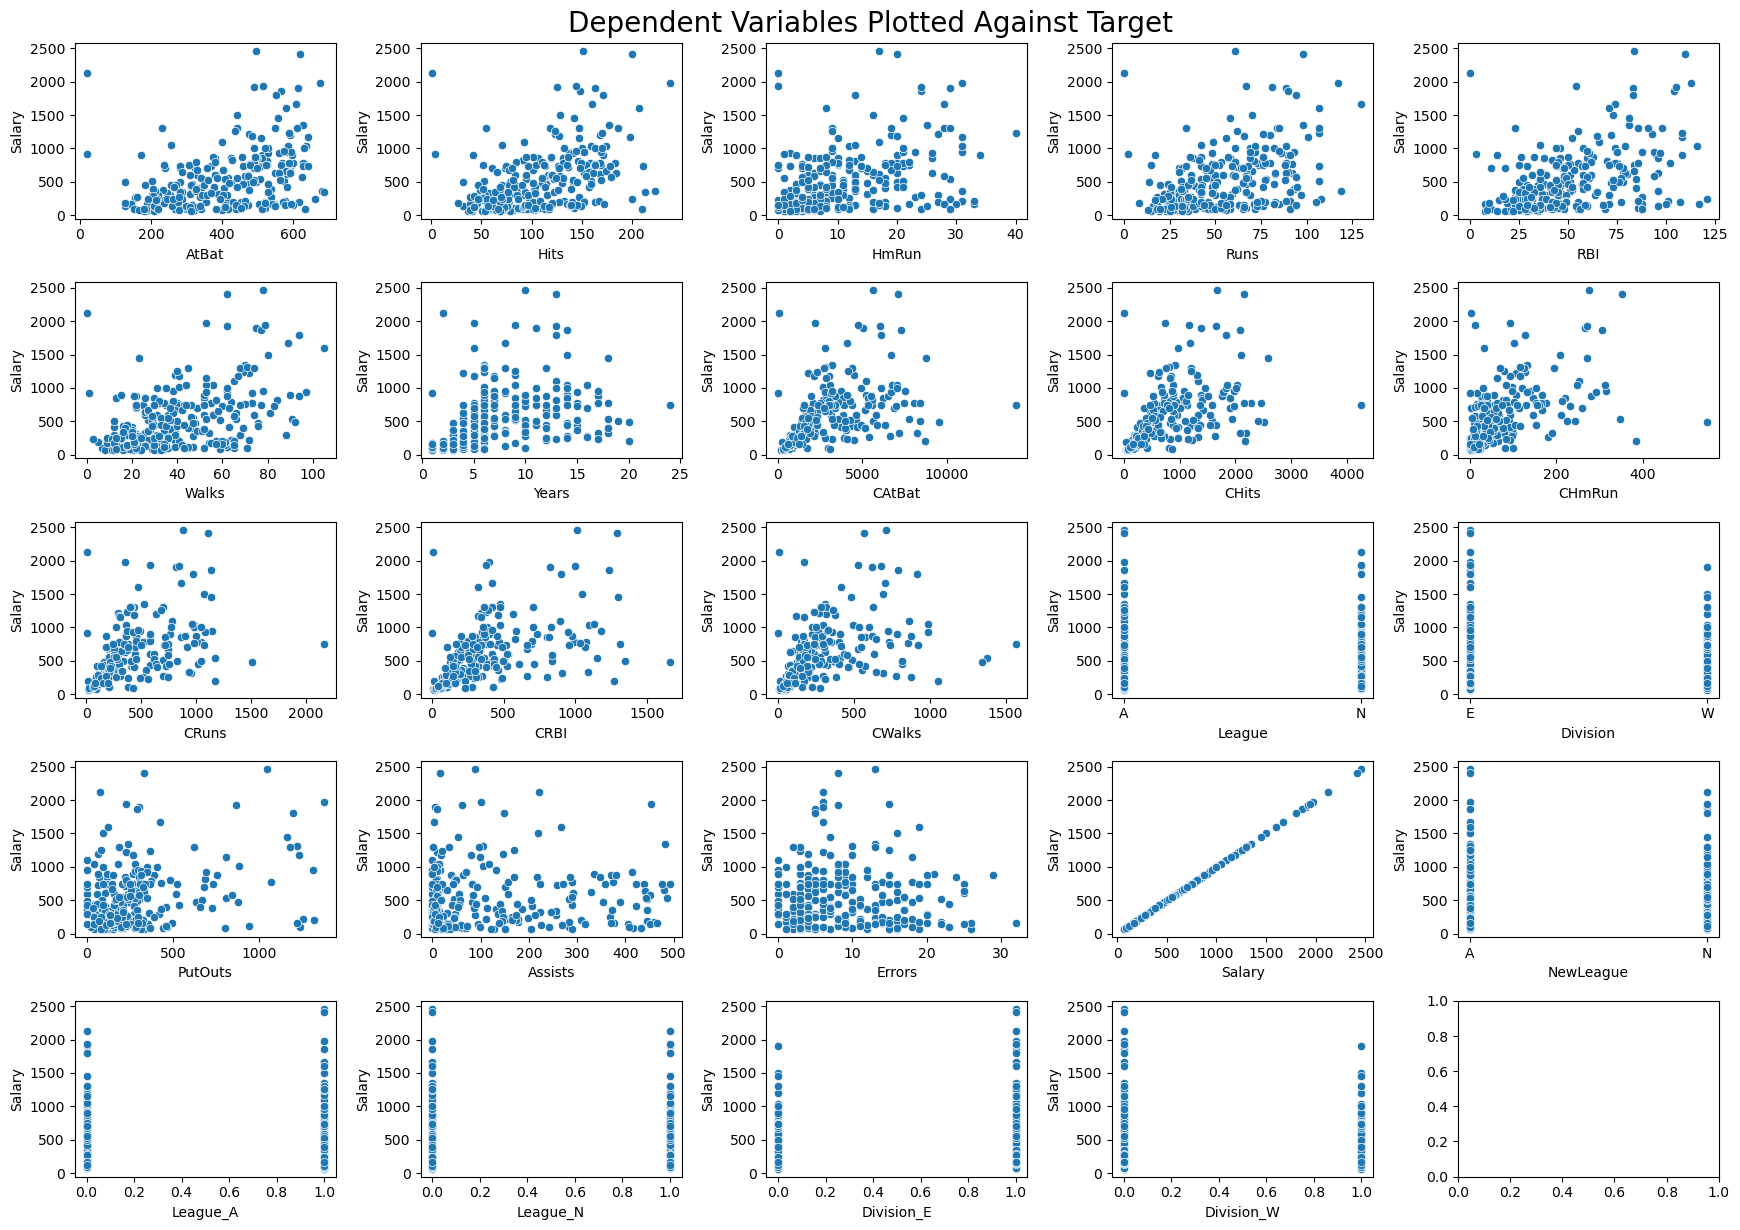

In [7]:
# Plot scatter
fig, ax = plt.subplots(5, 5, figsize=(17.5,12.5))
ax = ax.flatten()

for idx, feature in enumerate(df.columns):
    sns.scatterplot(data=df, x=feature, y='Salary', ax=ax[idx])
fig.suptitle('Dependent Variables Plotted Against Target', size=20)
fig.tight_layout()

plt.show()

**Notes:**
- **Variance in Salary tends to grow as feature values increase.**
    - Standardizing/transforming some features may help lower volatility.

### 1.2.4 Rookie Contract EDA
- Are there signals that point to artificially capped salaries in the data? 

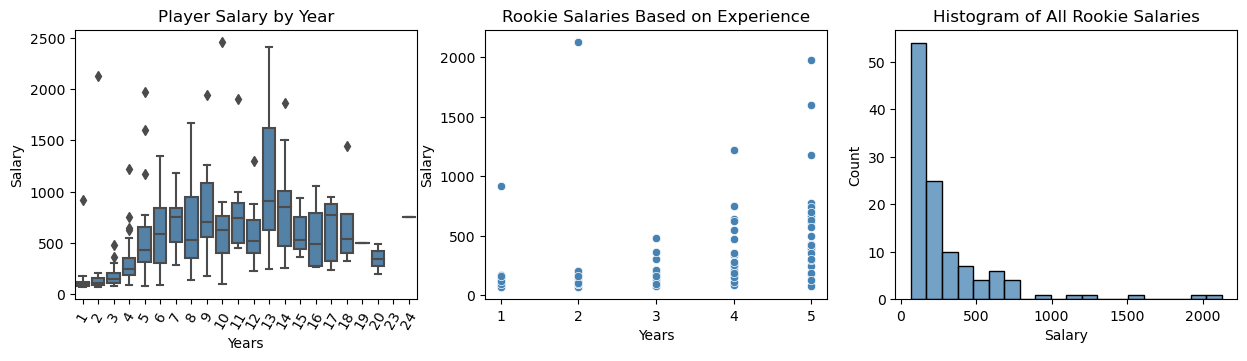

In [8]:
# Create Rookie Contract indicator
df['RookieContract'] = [1 if x < 6 else 0 for x in df.Years]

fig, ax = plt.subplots(1,3, figsize=(15,3.5))
sns.boxplot(data=df, x='Years', y='Salary', color='steelblue', ax=ax[0])
sns.scatterplot(data=df.loc[df.RookieContract==1], x='Years', y='Salary',color='steelblue', ax=ax[1])
sns.histplot(data=df.loc[(df.RookieContract==1)], x='Salary', color='steelblue', bins=20, ax=ax[2])
ax[0].set_title('Player Salary by Year')
ax[0].tick_params(axis='x', labelrotation=60)
ax[1].set_title('Rookie Salaries Based on Experience')
ax[2].set_title('Histogram of All Rookie Salaries')
plt.show()

**Notes:**

At Year 5, the average salary jumps by over 50% which is in line with the idea that rookie contracts contribute to pay deflation. This means that *Years* is the years of experience a player has at the start of the 1986 season. I.e. *Years*==5 in the dataset indicates that a player will have 6 full years by the end of 1986, allowing them to negotiate a new 1987 contract represented in the *Salary* feature.

Digging deeper, the salary disparity grows throughout the length of the rookie contract. This suggests a few things: 
1. Certain rookies may get paid more, which is likely true, but pay differences ranging from ~100k vs 2mil? I'm not sure about that. Years 1 and 2 would showing wider distributions if that was the reason behind within-Year outliers.
2. Additional stipulations may exist that allow certain rookies to hit the FA market or renegotiate contracts earlier than others. 

I'm going to assume (2) is true after reading a few more CBA links, since it sounds like certain rookies could renegotiate contracts after their first 3 or 4 seasons opposed to 6 based on performance.

In [9]:
# Redefine Rookie Contract where 2 or fewer years at the start of 1986 is a definite rookie 
# Players with 3-4 years may have been eligible for renegotation at the end of the 1984/1985 seasons
# Players with 5 years were likely FA's and seeing huge spikes in pay in the 1987 season if they were signed
df['RookieContract'] = [1 if yr < 3 else 0 for yr in df.Years]
df['PotentialEarlyNegotiation'] = [1 if yr == 3 or yr == 4 else 0 for yr in df.Years]

### 1.2.5 League Change EDA

In [10]:
# League and NewLeague comparison
df['LeagueChange'] = [1 if old!=new else 0 for old, new in zip(df.League, df.NewLeague)]
print(f'Players who stayed in same league: {(df.League==df.NewLeague).sum()}, {round((df.League==df.NewLeague).sum()*100/len(df),2)}%')
print(f'Players who changed leagues: {(df.League!=df.NewLeague).sum()}, {round((df.League!=df.NewLeague).sum()*100/len(df),2)}%')
print('\nSalary changes for league switch:\n---------------------------------')
df.groupby(['League', 'NewLeague']).agg(Salary=('Salary', 'mean')).reset_index()

Players who stayed in same league: 303, 94.1%
Players who changed leagues: 19, 5.9%

Salary changes for league switch:
---------------------------------


,League,NewLeague,Salary
0,A,A,541.014786
1,A,N,558.125000
2,N,A,486.000000
3,N,N,532.899737


**Notes:** 

- It appears that players switching into the NL resulted in larger contracts on average versus players who switched to the AL. Even if the trend is legitimate, the data is likely too sparse to have any meaningful impact in our model. Outliers more than likely drive this noise and I would expect feature selection to exclude LeagueChange from the final model.

### 1.2.6 Impute Missing Salary Values
- At this point, I'm comfortable enough with the current set of features to impute missing Salary values, so we'll go ahead and do that.

In [11]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
impute_cols = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'Salary', 'RookieContract',
               'PotentialEarlyNegotiation', 'LeagueChange']
imputed_df = pd.DataFrame(imputer.fit_transform(df[impute_cols]), columns=impute_cols)

df['Salary'] = imputed_df['Salary']

# Join null salary indicator
df = df.join(null_df['NullSalary'])

df.groupby('NullSalary')['Salary'].describe().T

NullSalary,0,1
count,263.000000,59.000000
mean,535.925882,474.946485
std,451.118681,325.853528
min,67.500000,72.900000
25%,190.000000,223.566700
50%,425.000000,444.500000
75%,750.000000,656.250000
max,2460.000000,1403.125400


**Notes:**
- Imputed salary distribution looks similar to non-imputed salaries, which indicates KNN was effective at identifying neighbors.

### 1.2.7 Correlation Matrix

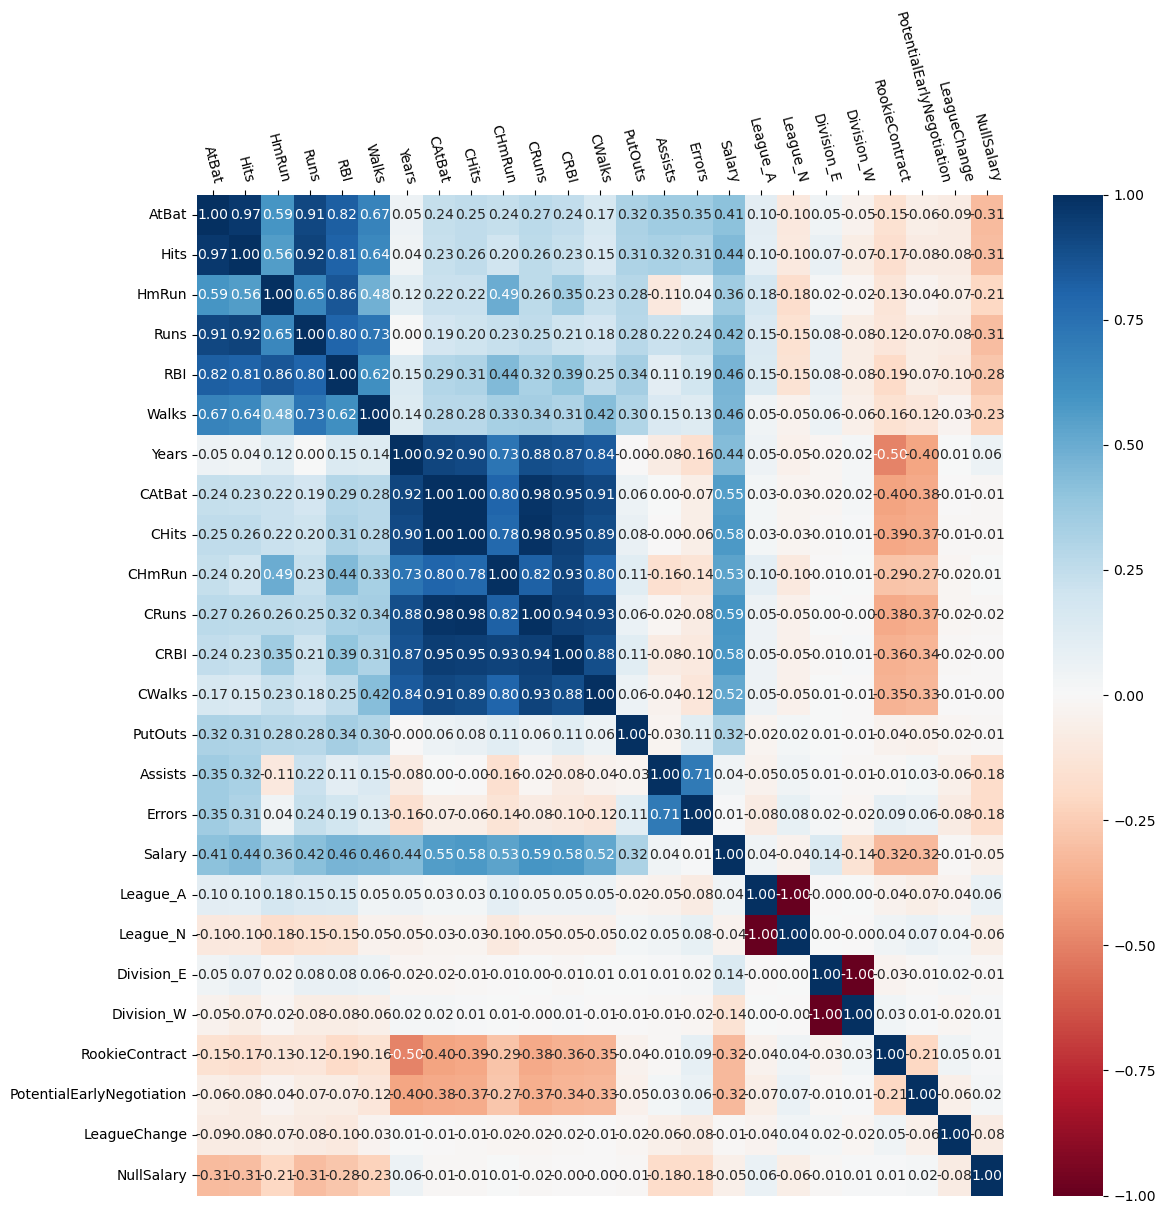

In [12]:
# Plot overall heatmap
fig, ax = plt.subplots(1,1, figsize=(13,13))

sns.heatmap(df.corr(),annot=True, cmap='RdBu', ax=ax, fmt='.2f')
ax.xaxis.tick_top()
plt.xticks(rotation=-75)
plt.show()

**Notes:** 
- **There is significant multicollinearity present which will make linear a regression a poor choice for a final model.**
    - We'll still look at a linear regression for an initial baseline and potentially an enhanced version, but will want to move away from it after that.

___

## 2. Linear Regression Model
#### V1 Summary
- **Model Details:**
    - **Model:** Linear Regression
        - *Pros:* Simple, straight forward approach that also smoothes variance 
        - *Cons:* Multicollinearity will make interpreting coefficients difficult
    - **Model Assumptions:**
        - Standard LR assumptions: constant variance in errors, features uncorrelated, linear relationship, normally distributed errors
    - **Feature Selection Process:** Stepwise regression with backwards elimination
        - Quick, easily interpretable output
    - **Variables Used:**
        - Salary (target), CAtBat, CHits, CRuns, CRBI, Years, PutOuts, PotentialEarlyNegotiation, RookieContract
- **Performance:**
    - RMSE: 325.55
    - MAE: 203.58
    - R2: 0.4721
- **Takeaways:**
    - Established that there is a significant difference between veteran players and those on rookie contracts
    - Right skew in Salary causes large underpredictions
    - Raw Career features may cause model to overestimate older players salaries and underestimate younger players  

## 2.1 Baseline Modeling and Feature Selection

### 2.1.1 Stepwise Regression Feature Selection
- Select features using a stepwise regression process with backwards elimination. If a feature has a p-value <0.10 then it remains in the model.

In [13]:
import statsmodels.formula.api as smf

# Model df
input_df = df[['Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague', 'RookieContract',
       'PotentialEarlyNegotiation', 'LeagueChange']]

####
# Determines model vars after stepwise regression process with backwards elimination
####

# Final selected model
model = smf.ols("Salary ~ CAtBat + CHits + CRuns + CRBI + Years + PutOuts + PotentialEarlyNegotiation + RookieContract",
                    data=input_df)
result = model.fit()
results_robust = result.get_robustcov_results(cov_type='HC3')
print(results_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     32.58
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           4.22e-37
Time:                        17:05:20   Log-Likelihood:                -2271.2
No. Observations:                 322   AIC:                             4560.
Df Residuals:                     313   BIC:                             4594.
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

**Notes:** 
- **Even though this is only a selection step, the R2 of 0.577 is encouraging.**
- **Multicollinearity shows many features are capturing the same signal.**
    - We already knew this would be the case from the correlation matrix, however it's good to see it confirmed in the regression output.

### 2.1.2 Linear Regression with Train/Test Split
- The regression was highly unstable the first few times that I ran it, so I opted to report a cross validated R2 to get a better sense of overall performance.
- The pipeline wasn't necessary but it cleans the code up

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.metrics as met
import numpy as np

# Version 1 data preprocessing
data = df[['Years', 'CAtBat', 'CHits', 'CRuns', 'CRBI',
       'PutOuts', 'RookieContract', 'PotentialEarlyNegotiation',
       'Salary']]
X = np.array(data.iloc[:, :-1])
y = np.array(data.iloc[:, -1])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),
                ('lr', LinearRegression())])

cross_val_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')

print('Cross Validated R2:', cross_val_scores.round(4))
print('Mean Cross Validated R2:', [round(cross_val_scores.mean(),4)])

pipeOut = pipe.fit(X_train, y_train)
yhat = pipeOut.predict(X_test)
print('Test R2 Score:', [round(met.r2_score(y_test, yhat), 4)])
print('Test RMSE:', round(met.root_mean_squared_error(y_test, yhat),2))
print('Test MAE:', round(met.mean_absolute_error(y_test, yhat),2))

Cross Validated R2: [0.7631 0.5661 0.4643 0.056  0.6955]
Mean Cross Validated R2: [0.509]
Test R2 Score: [0.4721]
Test RMSE: 325.55
Test MAE: 203.58


## 2.2 V1 Results Reporting

### 2.2.1 High-Level Error Analysis
- Cross Validated R2 indicates that the model is unstable because it produces starkly different results at each iteration. Linear regression is too simplistic a model, but I'll still develop it in V2 because the results are reportable and easy to communicate. It's my preference to always have a simpler model to use for high-level conversations and a complex model (often not needed) to use in production.
- **Test R2 is ~0.4721 meaning more than half of the variance in Salary is missed.**
    - I was pretty aggressive in terms of dropping features in the stepwise regression, so I'll look to expand the feature-space for V2 by adding existing features and engineering new ones.
- **Test RMSE is 325.55 and MAE is 203.58.**
    - I like listing both of these for a few reasons. First, RMSE is a common form of model measurement that is more robust to outliers via the square root. Since there are some very large salaries in the dataset relative to the mean it makes sense to use RMSE vs MSE. Second, MAE is a fantastic option for this task because it tells us how much our predicted salary differs from the actual salary *in dollars* on average. It's great for intuitive analysis. Does a model that's wrong by 203k on average sound good? It doesn't to me, so that's strong evidence that we need to do a lot more work on the prediction front.

### 2.2.2 Residuals Analysis
- How do residuals stack up against all model variables and for each contract group? 

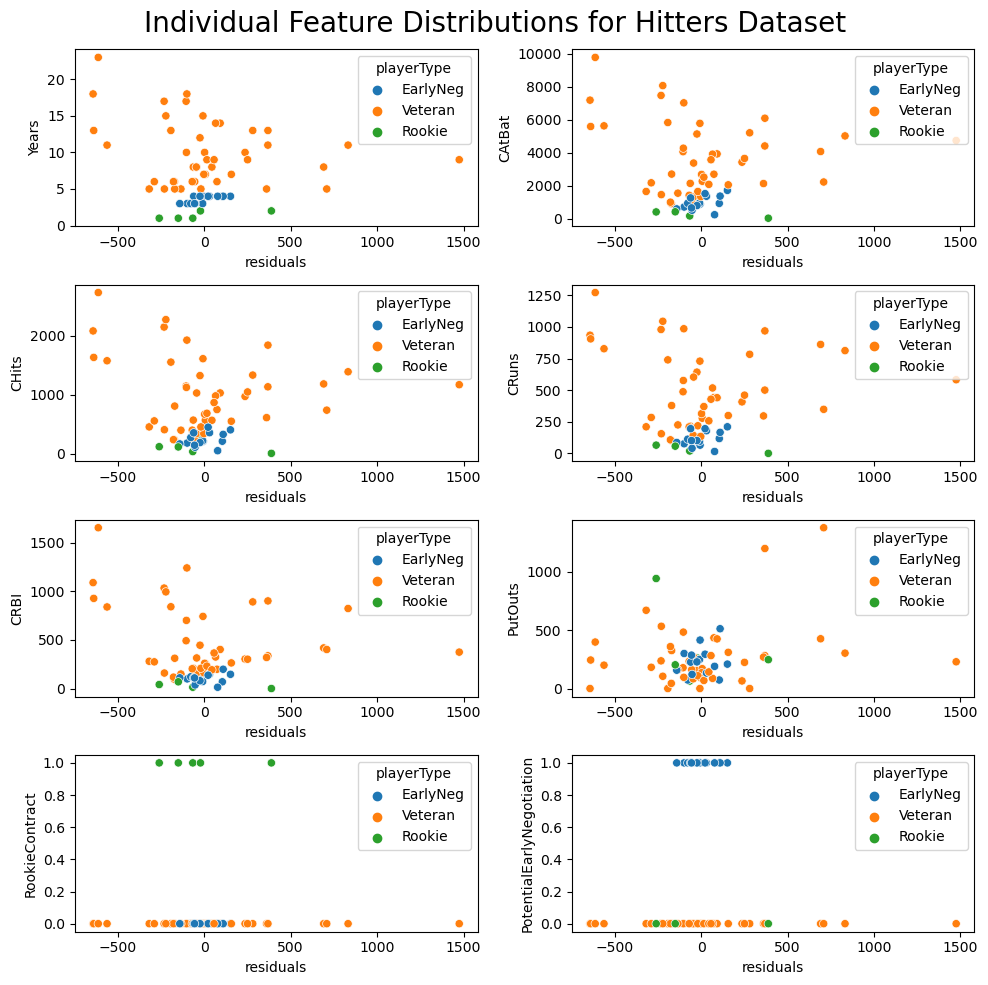

In [15]:
# Calculate residuals and plot
resid_df = pd.DataFrame(X_test, columns=data.columns[:-1])
resid_df['Salary'], resid_df['pSalary'] = y_test, yhat
resid_df['residuals'] = resid_df.Salary-resid_df.pSalary
resid_df['playerType'] = ['Rookie' if x.RookieContract==1 else ('EarlyNeg' if x.PotentialEarlyNegotiation==1 else 'Veteran') for _, x in resid_df.iterrows()]

fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax = ax.flatten()

# Plot 
for idx, feature in enumerate(resid_df.columns[:-4]):
    sns.scatterplot(data=resid_df, x='residuals', y=feature, hue='playerType', ax=ax[idx])
fig.suptitle('Individual Feature Distributions for Hitters Dataset', size=20)
fig.tight_layout()

plt.show()

**Notes:**
- **Veteran players (>6 years) have the largest residual spread, which makes sense because the gap in player talent becomes more evident and free agency removes the artificial cap on salaries.**
    - Keeping some form of Career metrics along with years of experience will help improve predictive power in the veteran group. From a business perspective, if we're using this model to guide negotiations then that's the only group we care about anyways.

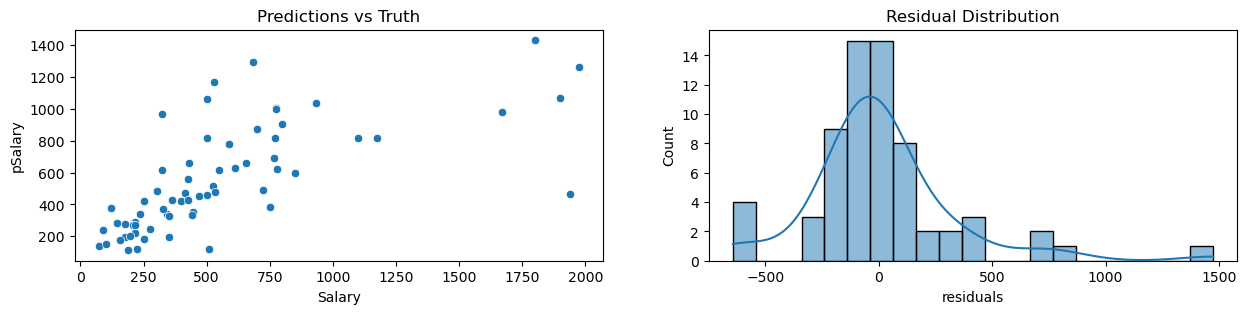

In [16]:
# Plot residuals
fig, ax = plt.subplots(1,2, figsize=(15,3))
sns.scatterplot(resid_df, x='Salary', y='pSalary', ax=ax[0])
sns.histplot(resid_df, x='residuals', kde=True)
ax[0].set_title('Predictions vs Truth')
ax[1].set_title('Residual Distribution')
plt.show()

**Notes**: 
- **The comparison plot shows a slight funnel shape, which violates linear regression homoskedasticity assumption**.
    - Prediction variance increases as Salary increases. This is a huge problem because as contracts get larger our model becomes more volatile, but we want the prediction error to have constant variance regardless of what salary range we're investigating.
- **The residual plot is actually somewhat normal which I didn't expect.**
    - Outliers are impacting our results considerably, but most errors are packed between +/- 500 which is a goos sign for this initial model.

___

# 3. Enhanced Linear Regression Model
#### V2 Summary
- **Overview:**
    - **Model:** Linear Regression with Log-transformed Target & LASSO Feature Selection
        - Controls for target skew while maintaining interpretability before moving onto a more complex solution
    - **Feature Selection Process:** LASSO
        - Selects features with greater rigor than stepwise regression
        - A low alpha (0.06) was identified as optimal, indicating that it didn't take a strong penalty to generate the final feature set
    - **Variables Used:**
        - lSalary (log transformed target), Years, RookieContract, pAtBat, pHits, pRuns, pRBI, pWalks, lCHmRun, lAssists
            - "p" = per-year
            - "l" = log-transformed
- **Performance:**
    - RMSE: 337.65
    - MAE: 213.38
    - R2: .4095
- **Takeaways:**
    - This model is a step back from V1 and it's likely because LASSO was too aggressive when it came to removing features and/or struggled due to non-linearity in the dataset
        - Cross Validated R2 does show tighter variance as a group though, so while this solution was more incorrect it was also less volatile.
    - Outliers are still causing problems in our prediction process.
        - There are players with little experience under contract for much higher salaries than expected. Do Rookie contracts include performance bonuses? We'd need more data to determine if this is the case.
    - The log transformation of Salary took care of heteroskedasticity concerns

## 3.1 Feature Engineering
- Most of the heavy lifting was done in the first section. Here we'll engineer per-year features and log transform right-skewed variables
    - I won't log transform per year variables because some of that variance should be preserved. I.e. I don't want to artificially compress the gap between a player who averages 40 homers a years versus one who averages 2.
- In a production environment I would write a few functions to make this engineering process more scalable.

### 3.1.1 Engineer New Features

In [17]:
# Engineer per year features
df['pAtBat'] = df['CAtBat'] / df['Years']
df['pHits'] = df['CHits'] / df['Years']
df['pHmRun'] = df['CHmRun'] / df['Years']
df['pRuns'] = df['CRuns'] / df['Years']
df['pRBI'] = df['CRBI'] / df['Years']
df['pWalks'] = df['CWalks'] / df['Years']

# Log transform career features (wait to transform Salary until after next cell block)
e = 1 # prevents np.log() from erroring out
df['lCAtBat'] = np.log(df['CAtBat']+e)
df['lCHits'] = np.log(df['CHits']+e)
df['lCHmRun'] = np.log(df['CHmRun']+e)
df['lCRuns'] = np.log(df['CRuns']+e)
df['lCRBI'] = np.log(df['CRBI']+e)
df['lCWalks'] = np.log(df['CWalks']+e)

# Log transform other
df['lPutOuts'] = np.log(df['PutOuts']+e)
df['lAssists'] = np.log(df['Assists']+e)
df['lErrors'] = np.log(df['Errors']+e)

### 3.1.2 Re-Impute Salary
- We should update null salaries because the feature set has changed.

In [18]:
# Reset salary
df['Salary'] = pd.read_csv(path)['Salary']

# Impute Salary again
imputer = KNNImputer(n_neighbors=5)
impute_cols = ['Years', 'Salary', 'League_A',
       'League_N', 'Division_E', 'Division_W', 'RookieContract',
       'PotentialEarlyNegotiation', 'LeagueChange', 'pAtBat',
       'pHits', 'pHmRun', 'pRuns', 'pRBI', 'pWalks', 'lCAtBat', 'lCHits',
       'lCHmRun', 'lCRuns', 'lCRBI', 'lCWalks', 'lPutOuts', 'lAssists', 'lErrors']

imputed_df = pd.DataFrame(imputer.fit_transform(df[impute_cols]), columns=impute_cols)

df['Salary'] = imputed_df['Salary']
df['lSalary'] = np.log(df['Salary']+e)

# Check Imputation
df.groupby('NullSalary')['Salary'].describe().T

NullSalary,0,1
count,263.000000,59.000000
mean,535.925882,466.764403
std,451.118681,228.144746
min,67.500000,116.000000
25%,190.000000,259.150000
50%,425.000000,459.500000
75%,750.000000,657.750000
max,2460.000000,977.999800


## 3.2 Post Feature Engineering EDA
- Because we've engineered per-year features, I'd argue there's no need to include 1986 statistics. Their inclusion will add more noise than legitimate signals.

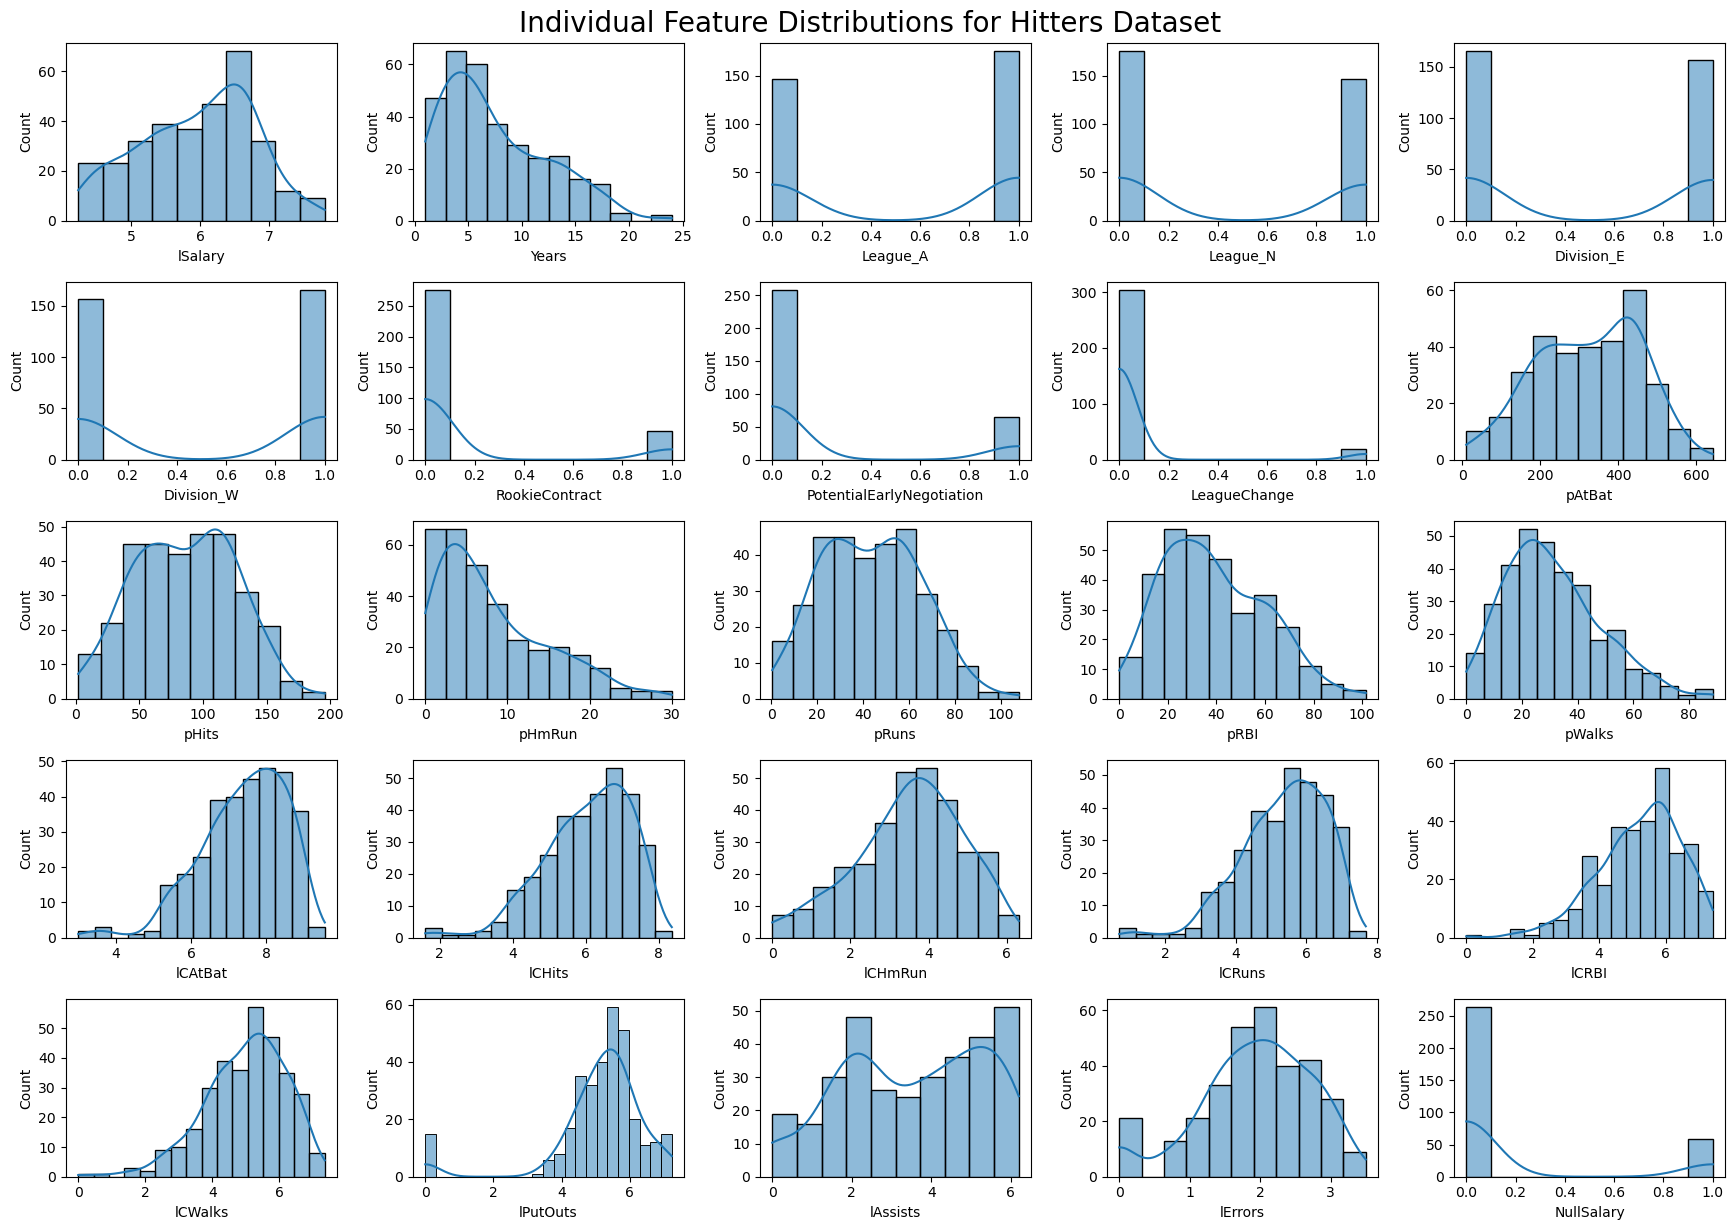

In [19]:
v2features = ['lSalary', 'Years', 'League_A',
       'League_N', 'Division_E', 'Division_W', 'RookieContract',
       'PotentialEarlyNegotiation', 'LeagueChange', 'pAtBat',
       'pHits', 'pHmRun', 'pRuns', 'pRBI', 'pWalks', 'lCAtBat', 'lCHits',
       'lCHmRun', 'lCRuns', 'lCRBI', 'lCWalks', 'lPutOuts','lAssists', 'lErrors', 'NullSalary']

fig, ax = plt.subplots(5, 5, figsize=(17.5, 12.5))
ax = ax.flatten()

for idx, feature in enumerate(v2features):
    sns.histplot(df[feature], ax=ax[idx], kde=True)
fig.suptitle('Individual Feature Distributions for Hitters Dataset', size=20)
fig.tight_layout()

plt.show()

## 3.3 Feature Selection
- Utilize LASSO to generate set of features for the model

In [20]:
from sklearn.linear_model import LassoCV

# Train test split
X = df[v2features].drop('lSalary', axis=1)
y = df['lSalary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify optimal alpha for selecting features
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
print('Optimal Alpha:', round(lasso.alpha_, 4))
selected_cols = list(X.columns[lasso.coef_!=0])
print('Selected Features:', selected_cols)

Optimal Alpha: 0.0626
Selected Features: ['Years', 'RookieContract', 'pAtBat', 'pHits', 'pRuns', 'pRBI', 'pWalks', 'lCHmRun', 'lAssists']


**Notes:**
- The optimal alpha can range from 0 to 1 with 0 being a pure OLS and 1 being a pure LASSO. The value of 0.0626 means it didn't take much penalization to trim our list to the selected features, which suggests these features are very closely tied to Salary.

## 3.4 Modelling
- Likely will be a replication of the V1 structure (linear regression?) with more refined features. Train/test split. Cross validation? 

In [21]:
# Set X and y
data = df[selected_cols+['lSalary']]
X = np.array(data.drop('lSalary', axis=1))
y = np.array(data['lSalary'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),
                ('lr', LinearRegression())])

cross_val_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')

print('Cross Validated R2:', cross_val_scores.round(4))
print('Mean Training R2:', [round(cross_val_scores.mean(),4)])

# Fit and predictions
pipeOut = pipe.fit(X_train, y_train)
yhat = pipeOut.predict(X_test)
yhat_e = [np.exp(x) for x in yhat]
y_test_e = [np.exp(x) for x in y_test]
print('Test R2 Score:', [round(met.r2_score(y_test, yhat), 4)])
print('Test RMSE:', round(met.root_mean_squared_error(y_test_e, yhat_e),2))
print('Test MAE:', round(met.mean_absolute_error(y_test_e, yhat_e),2))

Cross Validated R2: [0.6699 0.5897 0.3649 0.2255 0.5561]
Mean Training R2: [0.4812]
Test R2 Score: [0.4095]
Test RMSE: 337.65
Test MAE: 213.38


## 3.5 Results Reporting
### 3.5.1 High-Level Error Analysis
- **Cross Validated R2 suggests a more stable model despite a performance drop.**
- **Test R2 dropped from 0.47 to 0.41**
    - LASSO was likely overaggressive in terms of pruning features. I would run this again with Ridge and a larger, hand-picked set of features.
- **RMSE increased to 337.65 from 325.55 and MAE increased to 213.38 from 203.88.**
    - Again, the performance drop indicates that LASSO was not the right choice for feature selection. It's also an indication that non-linearities are present in the dataset and our methods are unable to pick up on them. Generally I see improvements when using more sophisticated feature selection processes.

### 3.5.2 Residuals Analysis

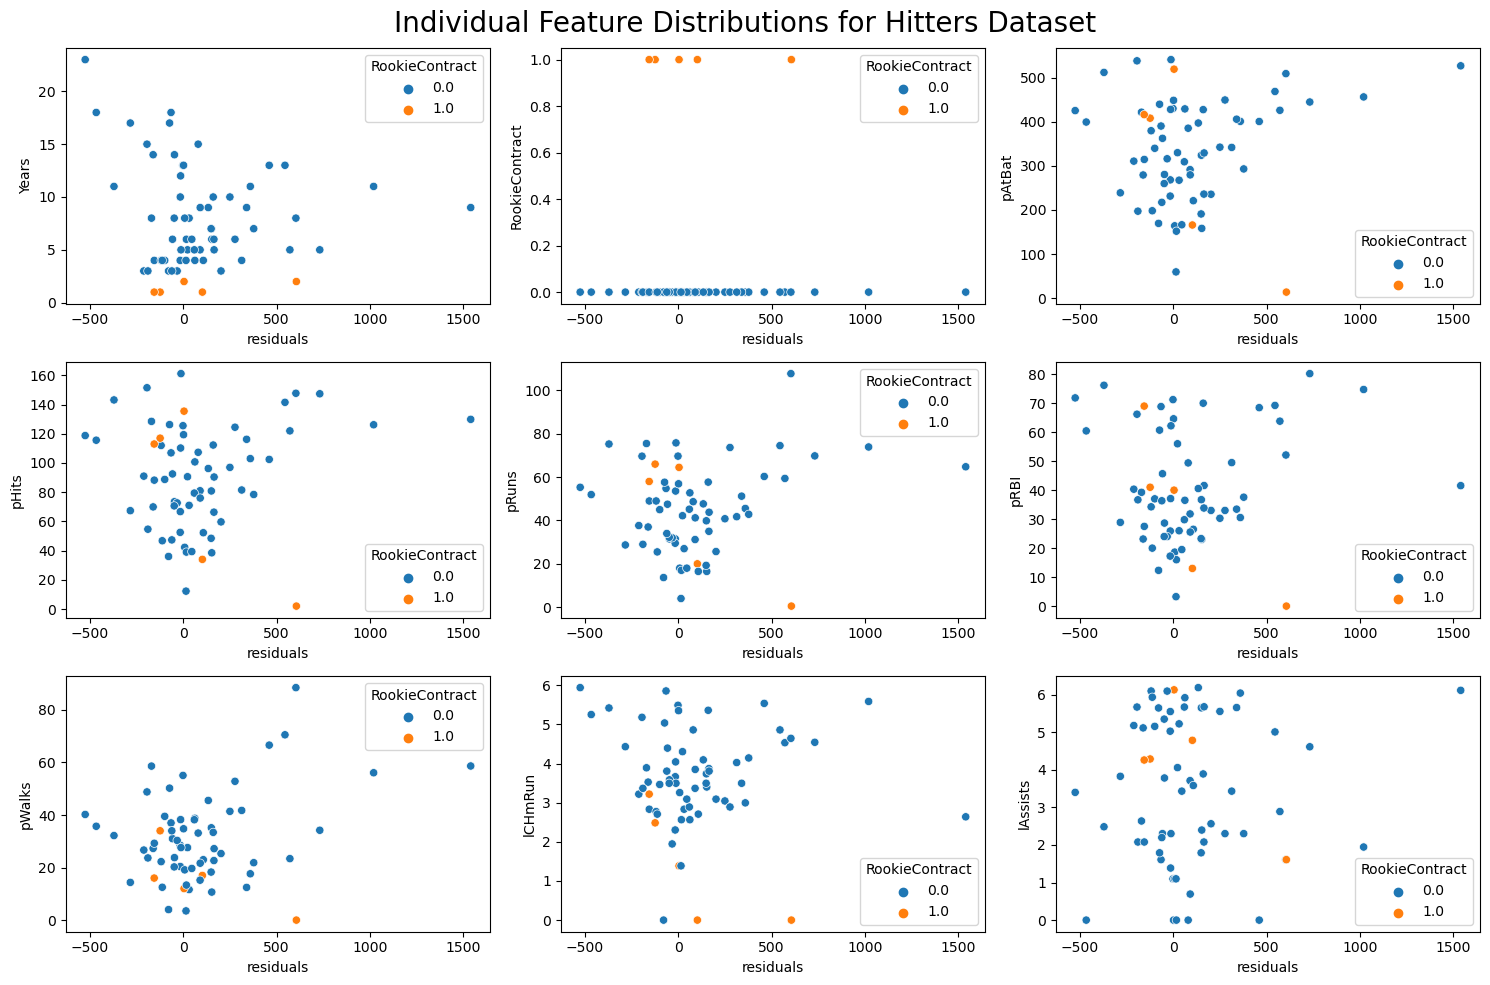

In [22]:
# Calculate residuals and plot
resid_df = pd.DataFrame(X_test, columns=selected_cols)
resid_df['Salary'], resid_df['pSalary'] = y_test_e, yhat_e
resid_df['lSalary'], resid_df['plSalary'] = y_test, yhat
resid_df['residuals'] = resid_df.Salary-resid_df.pSalary

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax = ax.flatten()

for idx, feature in enumerate(selected_cols):
    sns.scatterplot(data=resid_df, x='residuals', y=feature, hue='RookieContract', ax=ax[idx])
fig.suptitle('Individual Feature Distributions for Hitters Dataset', size=20)
fig.tight_layout()

plt.show()

In [23]:
resid_df.sort_values(by='residuals', ascending=False).head(5).round(2)

,Years,RookieContract,pAtBat,pHits,pRuns,pRBI,pWalks,lCHmRun,lAssists,Salary,pSalary,lSalary,plSalary,residuals
60,9.0,0.0,526.56,129.89,64.78,41.56,58.67,2.64,6.12,1941.00,401.28,7.57,5.99,1539.72
13,11.0,0.0,456.09,126.18,73.91,74.73,56.09,5.59,1.95,1901.00,881.60,7.55,6.78,1019.40
46,5.0,0.0,444.60,147.40,69.80,80.20,34.20,4.54,4.62,1976.00,1245.21,7.59,7.13,730.79
55,2.0,1.0,14.00,2.00,0.50,0.00,0.00,0.00,1.61,689.47,84.18,6.54,4.43,605.29
34,8.0,0.0,508.88,147.75,107.75,52.12,88.50,4.64,1.61,1671.00,1068.19,7.42,6.97,602.81


**Notes:**
- **Outliers are still having a major effect on the data as evidenced by the dataframe snapshot above.**
    - The 5 players listed don't have particularly good batting stats, but what's interesting is that 3 of them have very low assist totals (converting back to standard numbers they'd have under 10 assists per season). For this to be the case it's likely that these players were either injured or are designated hitters/first basement/catchers. If time permitted, I would do an investigation into assigning positions to players based on defensive statistics and knowledge of the sport.

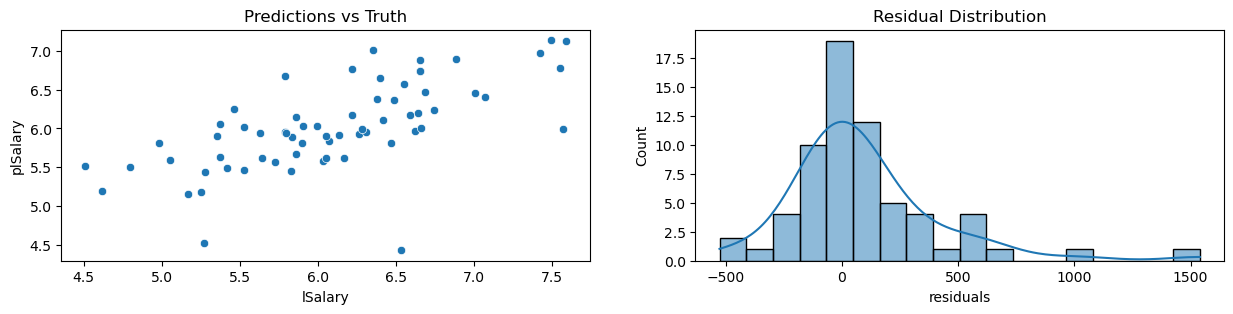

In [24]:
# Plot residuals
fig, ax = plt.subplots(1,2, figsize=(15,3))
sns.scatterplot(resid_df, x='lSalary', y='plSalary', ax=ax[0])
sns.histplot(resid_df, x='residuals', kde=True)
ax[0].set_title('Predictions vs Truth')
ax[1].set_title('Residual Distribution')
plt.show()

**Notes:**
- **The log transform took care of heteroskedasticity concerns**
    - Variance is generally uniform as lSalary increases.
- **Backtransformed residuals are have a wider variance than the initial model confirming that this was a step back**
- **Outliers are still an issue in our data and likely skewing error totals**

___

# 4. Random Forest w/ Tuning
### V3 Summary
- **Overview:**
    - **Model:** Random Forest with Hyperparameter Tuning
        - Controls for target skew while maintaining interpretability before moving onto a more complex solution
    - **Feature Selection Process:** Manual
        - Allow the forest to work with all features, excluding 1986 stats which are largely captured by per year variables.
- **Performance:**
    - RMSE: 326.91
    - MAE: 182.85
    - R2: 0.6985
- **Takeaways:**
    - The model performs about 15% better than in version 1 based on MAE and it's also significantly more stable.
    - Outliers are still causing problems in our prediction process.
        - There are players with little experience under contract for much higher salaries than expected. Do Rookie contracts include performance bonuses? We'd need more data to determine if this is the case.
    - RookieContract salaries are being predicted so well that we should consider creating two separate models. Rookies and Veterans seem to be distinct groups, so we may be adding noise by modelling them together.

## 4.1 Feature Engineering
- No additional feature engineering will be conducted in this portion.
    - Options for additional features could be:
        - offensive and defensive performance metrics that are weighted sums of offensive and defensive statistics
        - player positions estimated via clustering or some other grouping method
        - interaction terms
- PCA was also a potential option for feature engineering, however that is the least interpretable and I prefer not to use it in business use-cases where knowing "why" is so important.

## 4.2 Modelling 
- Random forest will be used for this final modelling portion for a few reasons: 
    1. The dataset is small, noisy, and has shortcomings ranging from missing salaries to lack of positional or team data. Because of this, I'd prefer to use a bagging approach since it's less likely to overfit based on noise in the data. There are ways to control for overfitting in either case, but I find RF to be more logical here.
    2. Tree-based models require far fewer assumptions. We no longer need to worry about heteroskedasticity or log transforming features since random forests are capable of dealing with non-linearities by design.
    3. Because there is so much we don't know (positions as one example), it's likely that there are signals buried in the dataset which a linear model cannot identify. The engineered features helped improve stability substantially, however we need to capture more complex relationships to improve performance.

### 4.2.1 Hyperparameter Tuning

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize regressor
rf = RandomForestRegressor(random_state=42)

# Hyperparameters to test
param_grid = {
    'n_estimators': [50, 100, 200], # more estimators smaller variance
    'max_features': [4, 6, 8], # more features more specificity, but also risk of overfitting
    'max_depth': [6, 8, 10], # deeper trees can pick up on more complexity but also overfit more
    'min_samples_split': [2, 5], # minimum samples required to split a node; higher = less overfitting
    'min_samples_leaf': [1, 2] # minimum samples required to be in a leaf; higher = less overfitting
}

# Initialize search
search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Resplit data
rf_features = ['League_A', 'League_N', 'Division_E', 'Division_W', 'RookieContract',
               'PotentialEarlyNegotiation', 'LeagueChange', 'NullSalary', 'pAtBat',
               'pHits', 'pHmRun', 'pRuns', 'pRBI', 'pWalks', 'CAtBat', 'CHits',
               'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors',
               'Years']
X = df[rf_features]
y = df['lSalary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model and print out best params
search.fit(X_train, y_train)
params = search.best_params_
print(params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


**Notes:**
- The parameters indicate the best model is rather large in terms of estimators with moderate depth and features
    - Maximal estimators minimizes final variance while moderate depth and features suggests a balance of bias and variance in the individual tree creation process.

### 4.2.2 Final Model

In [26]:
# Initialize regressor
rf = RandomForestRegressor(**params, random_state=42)

# Generate cross validated scores
cross_val_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')

# Output the results
print('Cross Validated R2:', cross_val_scores.round(4))
print('Mean Training R2:', [round(cross_val_scores.mean(),4)])

# Train model 
rf.fit(X_train, y_train)

# Print Results
yhat = rf.predict(X_test)
yhat_e = [np.exp(x) for x in yhat]
y_test_e = [np.exp(x) for x in y_test]

print('Test R2 Score:', [round(met.r2_score(y_test, yhat), 4)])
print('Test RMSE:', round(met.root_mean_squared_error(y_test_e, yhat_e),2))
print('Test MAE:', round(met.mean_absolute_error(y_test_e, yhat_e),2))

Cross Validated R2: [0.8384 0.7624 0.8275 0.6706 0.7564]
Mean Training R2: [0.7711]
Test R2 Score: [0.6985]
Test RMSE: 326.91
Test MAE: 182.85


## 4.3 Results Reporting
### 4.3.1 High-Level Error Analysis
- **Test R2 improved to 0.70 from 0.41.**
    - Much more of the variability is being captured in the this model relative to V2. We can see this directly in the feature residual plots where residuals tend to be bounded between +/- 400. The previous model had a greater residual spread, however it did perform better with outlier data which we'll discuss below.
- **RMSE decreased to 326.91 from 325.55 while MAE dropped to 213.38 from 182.85.**
    - On average, the final prediction has improved by about 10-15% in MAE. We still have latent issues with outliers, but that may require additional outside data in order to fix. 
- **Cross Validated R2 shows that this model is by far the most stable.**
    - Performance translates out of sample.

### 4.3.2 Feature Importances

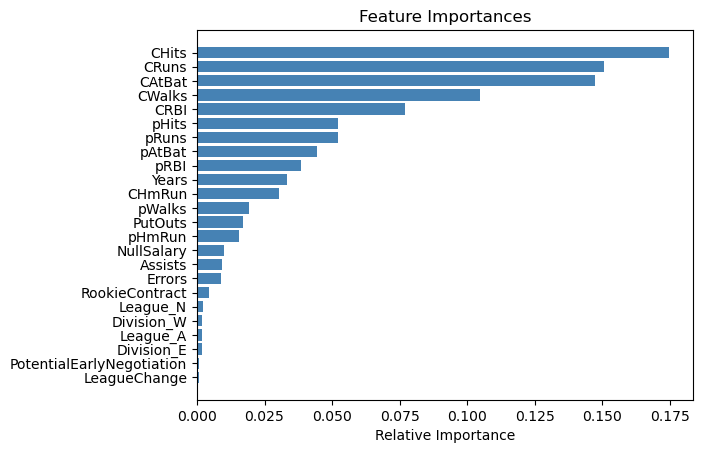

In [27]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='steelblue', align='center')
plt.yticks(range(len(indices)), [rf_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Notes:**
- Career totals and per year numbers are the most important for predictions, which makes sense because players who get paid more are the best on a per year basis and the most consistent over time. 
- The RookieContract feature has taken on less important since RandomForest is able to better capture discontinuities. I.e. Linear models smooth over the salary jump between rookies and veterans, but RandomForest can work with that sharp change.

### 4.3.3 Residual Plots

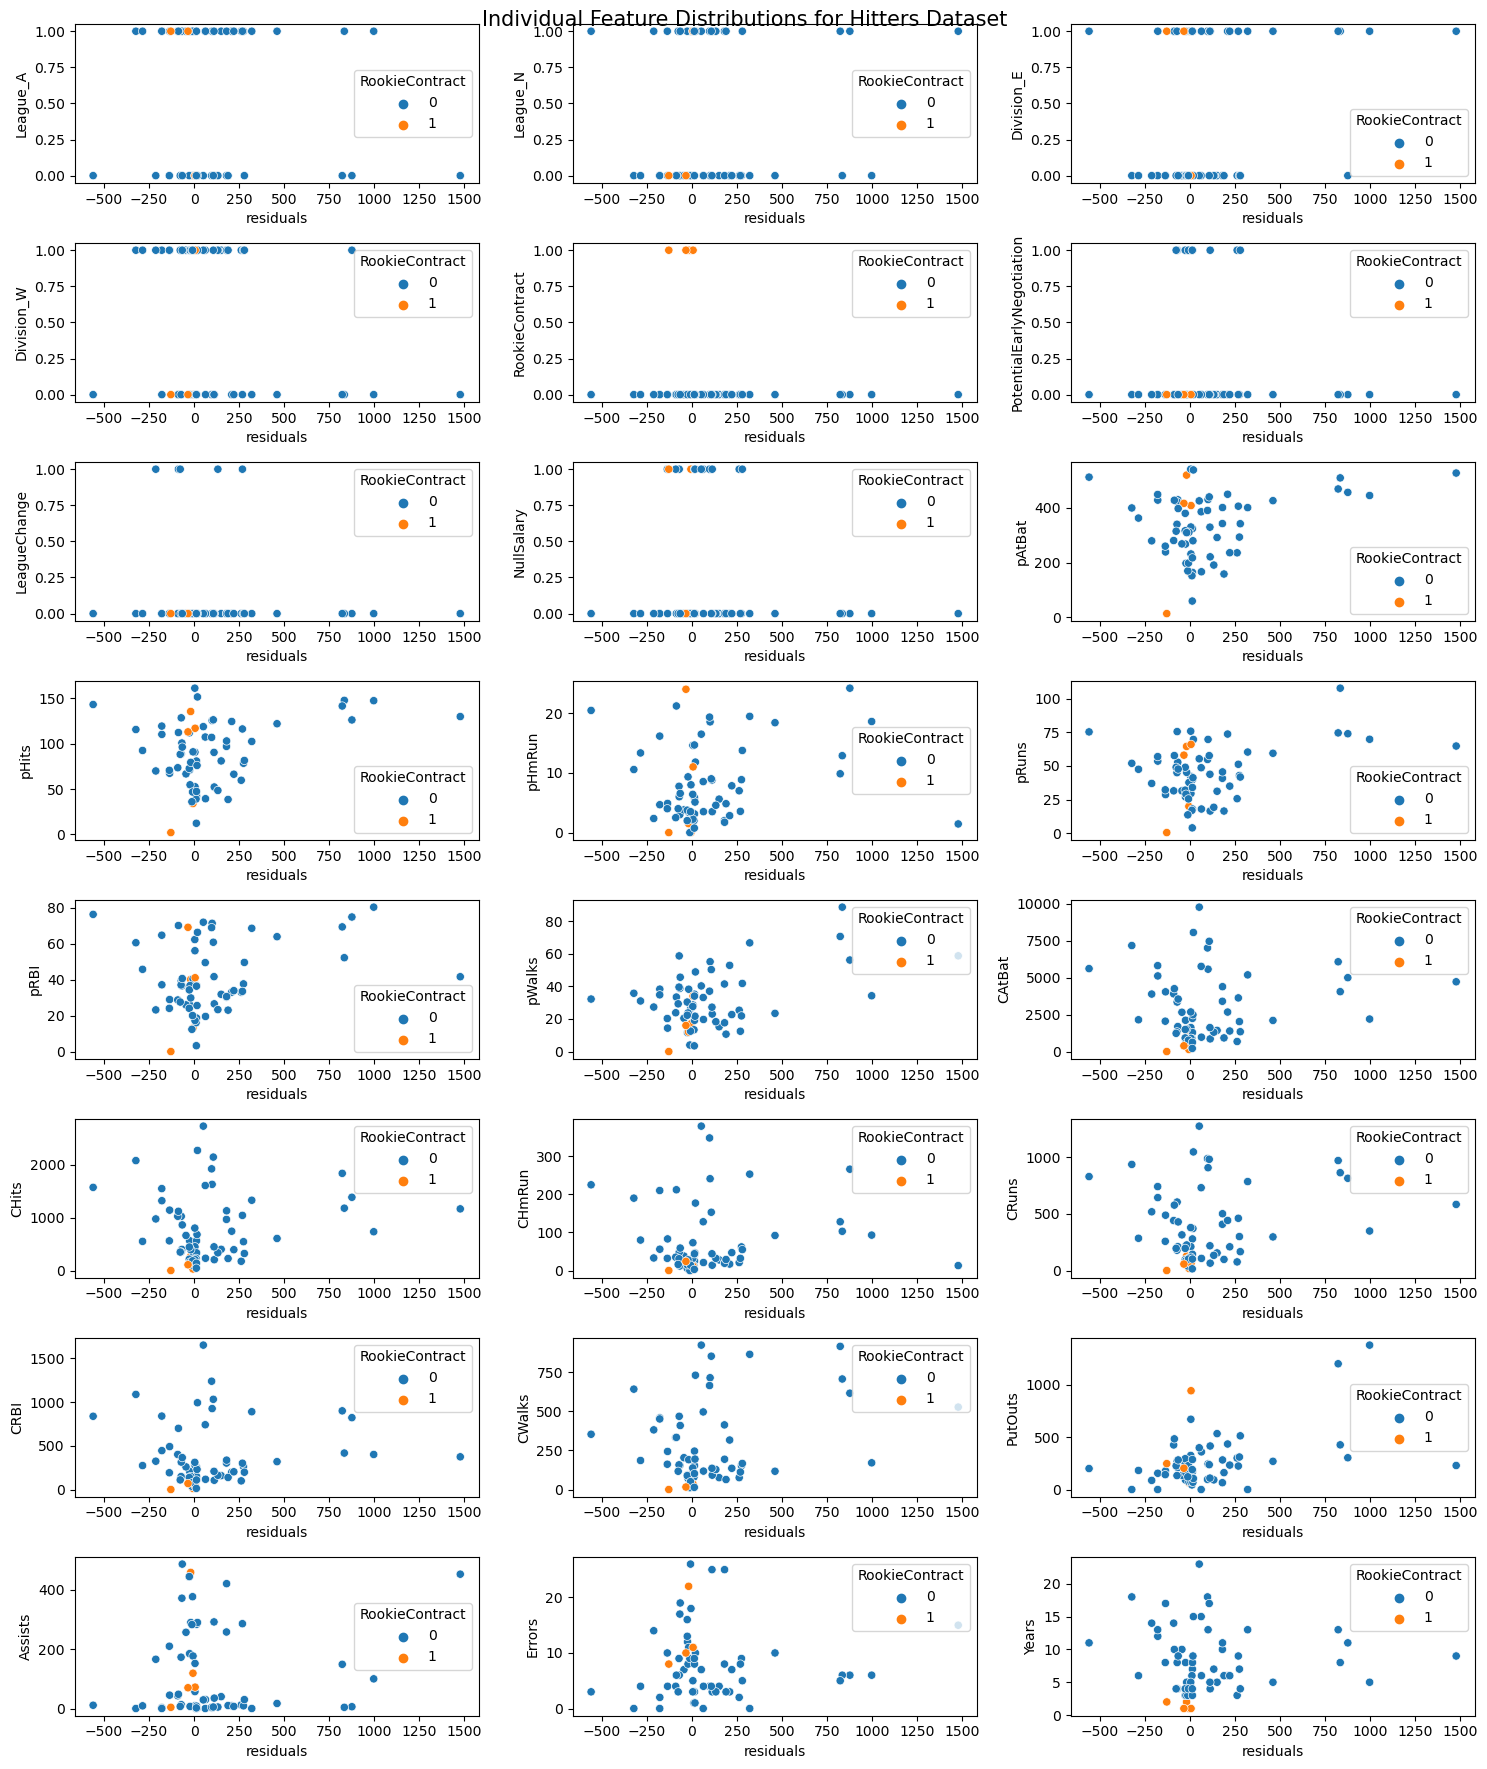

In [28]:
resid_df = pd.DataFrame(X_test, columns=rf_features)
resid_df['Salary'], resid_df['pSalary'] = y_test_e, yhat_e
resid_df['lSalary'], resid_df['plSalary'] = y_test, yhat
resid_df['residuals'] = resid_df.Salary-resid_df.pSalary

fig, ax = plt.subplots(8, 3, figsize=(15, 18))
ax = ax.flatten()

# PLot 
for idx, feature in enumerate(rf_features):
    sns.scatterplot(data=resid_df, x='residuals', y=feature, hue='RookieContract', ax=ax[idx])
fig.suptitle('Individual Feature Distributions for Hitters Dataset', size=15)
fig.tight_layout()

plt.show()

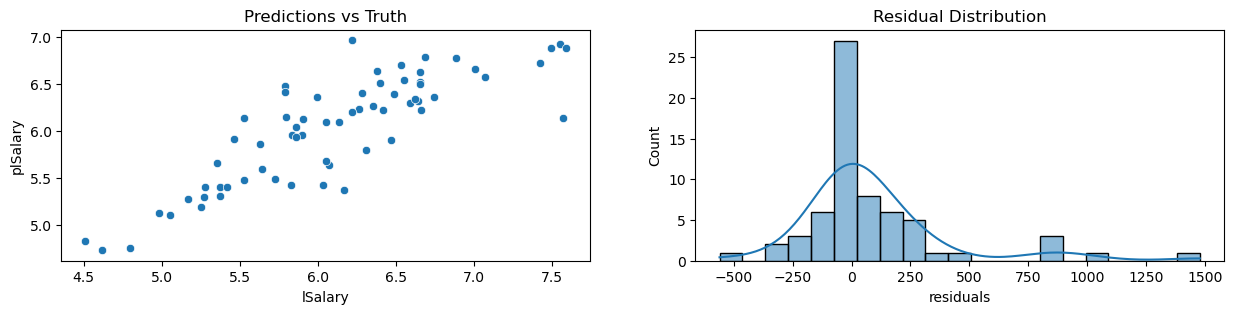

In [29]:
# Plot residuals
fig, ax = plt.subplots(1,2, figsize=(15,3))
sns.scatterplot(resid_df, x='lSalary', y='plSalary', ax=ax[0])
sns.histplot(resid_df, x='residuals', kde=True)
ax[0].set_title('Predictions vs Truth')
ax[1].set_title('Residual Distribution')
plt.show()

**Notes:**
- **This is easily the tightest residual plot so far indicating that we've achieved the best model in V3.**
- **Rookie contracts are handled well with only one observation appearing far from ground truth**
    - It probably makes sense to build separate models for Rookies and Veterans since we've captured Rookie signals well and could benefit by removing that bias from Veteran predictions.
- **Variance is generally constant in lSalary so we aren't "more incorrect" in certain places opposed to others,** which is important for a production model.
- **The residual distribution is tightly packed between +/- 250 further cementing improvements.**
    - Outlier issues have still not been addressed as evidence by the long tail.

___